In [1]:
import tensorflow as tf
import pathlib
from tensorflow import keras, lite
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


In [2]:
IMG_SIZE = 96
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32
CLASSES = 4
EPOCHS = 10
LEARNING_RATE = 0.0001
FINE_TUNE_EPOCHS = 10
FINE_TUNE_PERCENTAGE = 50


In [3]:
data_dir = pathlib.Path('Dataset/Training')
test_dir = pathlib.Path('Dataset/Testing')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                                data_dir,
                                                                validation_split = 0.2,
                                                                subset = 'training',
                                                                seed = 123,
                                                                image_size = (IMG_SIZE,IMG_SIZE),
                                                                batch_size = BATCH_SIZE
                                                              )
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                            data_dir,
                                                            validation_split = 0.2,
                                                            subset = 'validation',
                                                            seed = 123,
                                                            image_size = (IMG_SIZE,IMG_SIZE),
                                                            batch_size = BATCH_SIZE
                                                            )
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                            test_dir,
                                                            seed = 123,
                                                            image_size = (IMG_SIZE,IMG_SIZE),
                                                            batch_size = BATCH_SIZE
                                                            )

Found 1800 files belonging to 4 classes.
Using 1440 files for training.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Found 1800 files belonging to 4 classes.
Using 360 files for validation.
Found 40 files belonging to 4 classes.


2022-06-18 18:46:51.876167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-18 18:46:51.876468: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
from keras.layers import  GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(weights='imagenet',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3),
                        include_top=False)

base_model.trainable = False

def model_maker():
  inputs = keras.Input(shape=(96,96,3))
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = GlobalAveragePooling2D()(x)
  x = Dense(128, activation = 'relu')(x)
  x = Dropout(0.25)(x)
  outputs = Dense(CLASSES, activation='softmax')(x)
  model = keras.Model(inputs, outputs)
  return model

In [5]:
model = model_maker()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

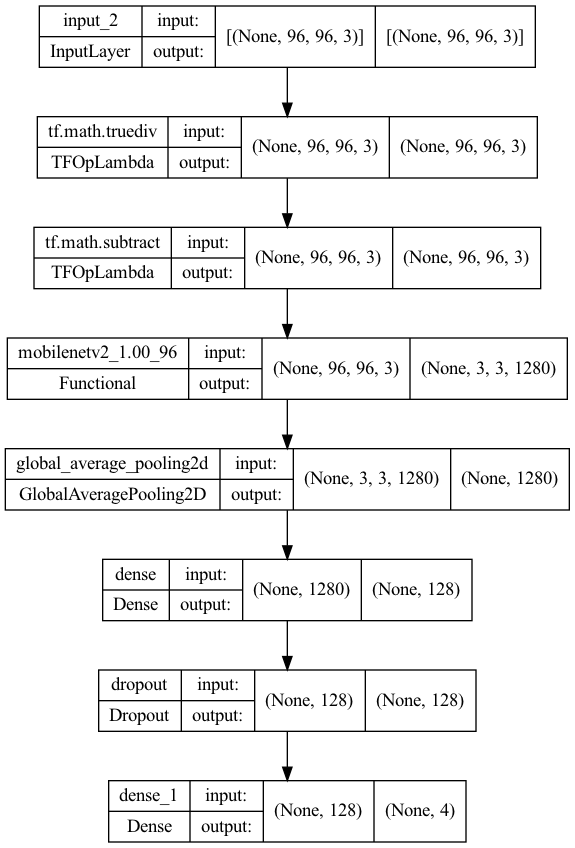

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
               loss = 'sparse_categorical_crossentropy',
               metrics = ['accuracy'])

In [8]:
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = EPOCHS,
                    )

Epoch 1/10


2022-06-18 18:46:54.405561: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-18 18:46:54.406237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44/45 [============================>.] - ETA: 0s - loss: 0.9785 - accuracy: 0.5987

2022-06-18 18:46:56.493940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 4s 52ms/step - loss: 0.9689 - accuracy: 0.6049 - val_loss: 0.5204 - val_accuracy: 0.8500
Epoch 2/10
45/45 [==============================] - 2s 38ms/step - loss: 0.4137 - accuracy: 0.8875 - val_loss: 0.2814 - val_accuracy: 0.9528
Epoch 3/10
45/45 [==============================] - 2s 41ms/step - loss: 0.2456 - accuracy: 0.9486 - val_loss: 0.1856 - val_accuracy: 0.9833
Epoch 4/10
45/45 [==============================] - 2s 38ms/step - loss: 0.1628 - accuracy: 0.9729 - val_loss: 0.1387 - val_accuracy: 0.9833
Epoch 5/10
45/45 [==============================] - 2s 41ms/step - loss: 0.1224 - accuracy: 0.9792 - val_loss: 0.1063 - val_accuracy: 0.9833
Epoch 6/10
45/45 [==============================] - 2s 38ms/step - loss: 0.0885 - accuracy: 0.9896 - val_loss: 0.0887 - val_accuracy: 0.9889
Epoch 7/10
45/45 [==============================] - 2s 38ms/step - loss: 0.0706 - accuracy: 0.9938 - val_loss: 0.0768 - val_accuracy: 0.9889
Epoch 8/10
45/45 [======

In [9]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

12/12 [==============================] - 0s 28ms/step - loss: 0.0590 - accuracy: 0.9889
Test accuracy : 0.9888889193534851


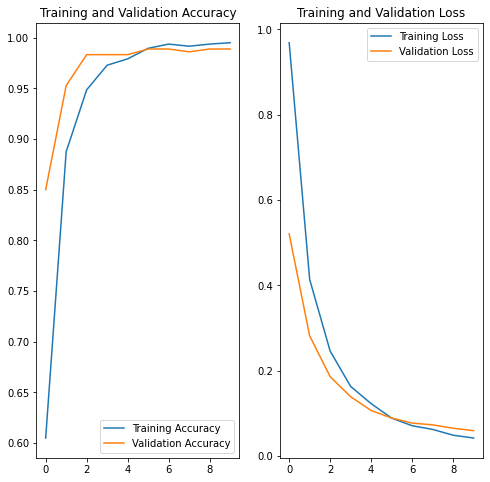

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
# import math

# print('Fine-tuning best model for {} epochs...'.format(FINE_TUNE_EPOCHS), flush=True)

# model_layer_count = len(model.layers)
# fine_tune_from = math.ceil(model_layer_count * ((100 - FINE_TUNE_PERCENTAGE) / 100))

# model.trainable = True
# for layer in model.layers[:fine_tune_from]:
#     layer.trainable = False

# total_epochs = EPOCHS + FINE_TUNE_EPOCHS
 
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000045),
#                 loss='sparse_categorical_crossentropy',
#                 metrics=['accuracy'])

# history_fine =  model.fit(train_ds,
#                     epochs=total_epochs,
#                     initial_epoch=history.epoch[-1],
#                     validation_data=val_ds,
#                 )

In [12]:
# acc += history_fine.history['accuracy']
# val_acc += history_fine.history['val_accuracy']

# loss += history_fine.history['loss']
# val_loss += history_fine.history['val_loss']
# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
# plt.plot([EPOCHS-1,EPOCHS-1],
#           plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
# plt.plot([EPOCHS-1,EPOCHS-1],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

1/2 [==============>...............] - ETA: 0s

2022-06-18 18:47:14.822334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 80ms/step
there were 10 correct predictions in 40 tests for an accuracy of  25.00 % 


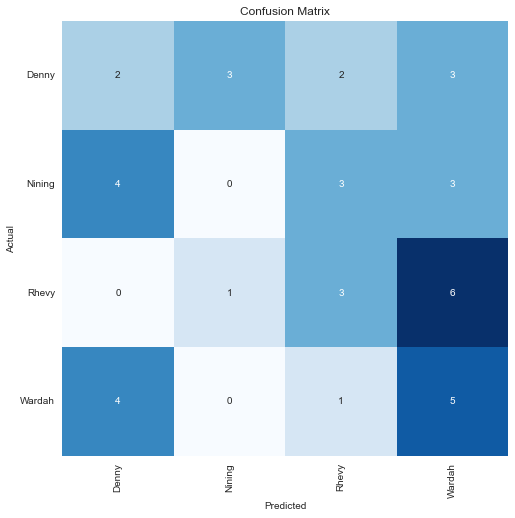

Classification Report:
----------------------
               precision    recall  f1-score   support

       Denny       0.20      0.20      0.20        10
      Nining       0.00      0.00      0.00        10
       Rhevy       0.33      0.30      0.32        10
      Wardah       0.29      0.50      0.37        10

    accuracy                           0.25        40
   macro avg       0.21      0.25      0.22        40
weighted avg       0.21      0.25      0.22        40



In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_style('darkgrid')
classes=test_ds.class_names # ordered list of class names
ytrue=[]
for images, label in test_ds:   
    for e in label:
        ytrue.append(classes[e]) # list of class names associated with each image file in test dataset 
ypred=[]
errors=0
count=0
preds=model.predict(test_ds, verbose=1) # predict on the test data
for i, p in enumerate(preds):
    count +=1
    index=np.argmax(p) # get index of prediction with highest probability
    klass=classes[index] 
    ypred.append(klass)  
    if klass != ytrue[i]:
        errors +=1
acc= (count-errors)* 100/count
msg=f'there were {count-errors} correct predictions in {count} tests for an accuracy of {acc:6.2f} % '
print(msg) 
ypred=np.array(ypred)
ytrue=np.array(ytrue)
if len(classes)<= 30: # if more than 30 classes plot is not useful to cramed
        # create a confusion matrix 
        cm = confusion_matrix(ytrue, ypred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
clr = classification_report(ytrue, ypred, target_names=classes)
print("Classification Report:\n----------------------\n", clr)

In [14]:
# import numpy as np
# import cv2

# # multiple cascades: https://github.com/Itseez/opencv/tree/master/data/haarcascades

# #https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
# face_cascade = cv2.CascadeClassifier('Haar/haarcascade_frontalface_default.xml')
# #https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_eye.xml
# eye_cascade = cv2.CascadeClassifier('Haar/haarcascade_eye.xml')

# # mouth_cascade = cv2.CascadeClassifier('haarcascade_smile.xml')

# cap = cv2.VideoCapture(0)
# while 1:
#     ret, img = cap.read()
#     img = cv2.flip(img, 1)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     faces = face_cascade.detectMultiScale(gray, 1.1, 3)

#     for (x,y,w,h) in faces:
#         roi_gray = gray[y:y+h, x:x+w]
#         roi_color = img[y:y+h, x:x+w]
#         roi_color = cv2.resize(roi_color, (96, 96))
#         eyes = eye_cascade.detectMultiScale(roi_gray)
#         for (ex,ey,ew,eh) in eyes:
#             cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
#             img_array = tf.keras.utils.img_to_array(roi_color)
#             img_array = tf.expand_dims(img_array, 0) # Create a batch

#             predictions = model.predict(img_array)
#             score = tf.nn.softmax(predictions[0])
#             text = "{} : {:.2f}".format(classes[np.argmax(score)], 100 * np.max(score))
#             img = cv2.putText(img, text, (x,y+h+20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)


#     cv2.imshow('img',img)
#     k = cv2.waitKey(1) & 0xff
#     if k == 27:
#         break


# cv2.destroyAllWindows()
# cv2.waitKey(1)
# cap.release()

In [15]:
# class_names = classes

# denny_face = "Dataset/Testing/Denny/00001.jpg"
# img = tf.keras.utils.load_img(
#     denny_face, target_size=(96, 96)
# )
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )
# print(predictions)

In [16]:
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices((images)).batch(1).take(100):
    yield [tf.dtypes.cast(data, tf.float32)]


# Convert the tflite.
converter = lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

# Save the model.
with open('trained.tflite', 'wb') as f:
  f.write(tflite_quant_model)

2022-06-18 18:47:18.584781: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/3g/y_pk3n0d7rl68gs62_42w3p80000gn/T/tmpvs37me9n/assets


/Users/denuradhan/miniforge3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-06-18 18:48:12.963674: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-06-18 18:48:12.963696: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-06-18 18:48:12.964579: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/3g/y_pk3n0d7rl68gs62_42w3p80000gn/T/tmpvs37me9n
2022-06-18 18:48:12.982919: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-06-18 18:48:12.982938: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/3g/y_pk3n0d7rl68gs62_42w3p80000gn/T/tmpvs37me9n
2022-06-18 18:48:13.073397: 